### Author: Md Fahim Hasan
### Work Email: mdfahim.hasan@bayer.com

# Read Me

This script queries data of 250m resolution [Soil250](https://cswarehouse.io/datasets/location360/soil/soil250/) __V1__ and __V2__ data from the [Crop Science Warehouse](https://cswarehouse.io) (CSW).


### Region of Interest (ROI)
The data is downloaded for some `selected cities in Califoania`. This Region of Interest (ROI) is selected consisting of some parts of the Central Valley, California that has significant agriculture. The ROI selection was based on consideration that it should overlap some `Testing Fields` in that region.


### Querying for each City Individually
The soil250 data is of 250m resolution, therefore, the query size is quite large. If the query was set up for the whole ROI at once, the `user query` limit for a single day from CSW exceedes. So, the query has to be set up in a way that it can be performed for individual cities. For example, to avoid exceedance of user query limit, I downloaded for a couple cities in each day. In total, it took me `3/4 days` to query for our whole ROI.


### Deciding value for `query_breaks`
This script uses `query_soil_data_on_hid_h3` function (from `query_utils.ipynb` script) for downloading the Soil250 data. There is an argument `query_breaks` in the function. `query_breaks` decides how many chunks of hid/h3 have to be made. The `query_soil_data_on_hid_h3` function queries data for each of the chunks at a time and afterwards compile them together. Querying by chunk helps improving querying speed as it queries multiple records together. Setting the `query_breaks` value large will create many chunks and query them one by one, thus reducing query speed if an optimum number isn't selected. On the other hand, setting the `query_breaks` value too small will create large chunks to be queried together and it might fail. Therefore, setting an `optimum value` for the argument `query_breaks` is crucial. 


### File Format of queried dataset 
The downloaded soil dataframe has the hid + h3 info. But it's not a geodataframe. We are saving the queried dataframe as a parquet file. And trying to save the dataframe as a geodataframe in parquet format causes `kernel died` / `memory issue`.  Therefore, I didn't save it as a geodataframe. Instead, I created the `read_h3_parquet_as_geodataframe` function which can read the saved parquet file (dataframe) as geodataframe without needing to save it (there is option to save, but not utilizing it), and further processing like plotting the geodataframe, converting it to raster can be performed. I have demostrated an example below in the script. 


__Note:__
- The function used in this script can be found in `query_utils.ipynb` in the `query_codes` folder. 
- The ROI shapefile can be found in the `shapefiles_grids` folder in the main folder of the repo.


__Dataset ID (in Location360 Datasets in CSW):__

-  soil250 V1: location360-datasets.environmental_data_cube.isric_global_soil_250
- soil250 V2: location360-datasets.environmental_data_cube.isric_global_soil_250_v2

In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt

from ipynb.fs.full.query_utils import *

## Querying California's city geometry

First, I am querying California's city geometry using the `extract_L3_geom_by_country_state` function from the `query_utils.ipynb` script. The `extract_L3_geom_by_country_state` function uses country_code ('US') and L1 level (state_name; California in this case) info to query L3 level geometry data from CSW [Geopolitical Data L3](https://cswarehouse.io/datasets/location360/geopolitical/) dataset.

In [3]:
california_L3_gdf = extract_L3_geom_by_country_state(output_shapefile='../shapefiles_grids/California_L3.shp', 
                                                     country_code='US', state_name='California', 
                                                     bq_project='location360-datasets')

Downloading: 100%|██████████|


/home/ec2-user/SageMaker/data_pipeline/data-pipeline-env-model/query_codes/query_utils.ipynb:91: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  "        query = f\"\"\"\n",


<Axes: >

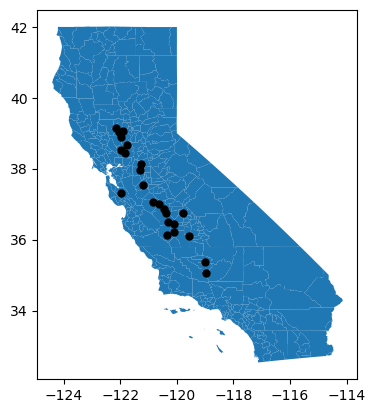

In [24]:
# loading testing field geometry
testing_field = '../shapefiles_grids/testing_sites.shp'
testing_field_gdf = gpd.read_file(testing_field)

# loading queried L3 geomtery for California
california_L3_gdf= gpd.read_file('../shapefiles_grids/California_L3.shp')

# Plotting
fig, ax = plt.subplots()
base = california_L3_gdf.plot(ax=ax)
testing_field_gdf.plot(ax=base, color='black', marker='o', markersize=25)

Here, the black dots represents the `testing fields` in California. Based on the testing fields, I am selecting 30 cities for which I will download soil250 data. Selected the cities with QGIS`

## Loading the Region of Interest (ROI)

A part of `central valley, California` was selected as the ROI.

In [20]:
selected_cities = gpd.read_file('../shapefiles_grids/selected_cities_California.shp')
selected_cities.head()

,country,country_co,state_prov,county_dis,city,geometry
0,United States of America,US,California,Yolo County,Winters CCD,"POLYGON ((-122.04501 38.65057, -122.04201 38.6..."
1,United States of America,US,California,Yolo County,Woodland CCD,"POLYGON ((-121.63803 38.74952, -121.63707 38.7..."
2,United States of America,US,California,Yolo County,Davis CCD,"POLYGON ((-121.68728 38.65387, -121.68068 38.6..."
3,United States of America,US,California,Yolo County,Esparto CCD,"POLYGON ((-122.06176 38.92586, -122.06112 38.9..."
4,United States of America,US,California,Yolo County,Knights Landing CCD,"POLYGON ((-122.02380 38.92593, -122.02083 38.9..."


<Axes: >

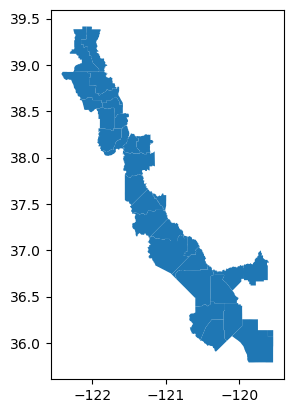

In [21]:
selected_cities.plot()

## Downloading Data for selected Cities of California

There are 30 cities in our selected ROI. The city `Coalinga` is very large generating large query size. So, I spliitted that into two parts `Coalinga CCD` and `Coalinga CCD 2`. This makes the total number of polygons `31` in the `california_cities` dataframe. 

We will load the shapefile as geoDataFrame (gdf) and loop through each city in the gdf. The `query_srtm_elevation_data_on_hid_h3` function will query data for each of the cities individually and save the queried data as a parquet file individually with the city's name in the suffix. 

In [19]:
california_cities = selected_cities['city'].to_list()
print(len(california_cities))
california_cities

31


['Winters CCD',
 'Woodland CCD',
 'Davis CCD',
 'Esparto CCD',
 'Knights Landing CCD',
 'Clarksburg CCD',
 'Stratford CCD',
 'Corcoran CCD',
 'Central Colusa CCD',
 'East Colusa CCD',
 'Firebaugh CCD',
 'Fresno CCD',
 'Huron CCD',
 'Mendota CCD',
 'Coalinga CCD 2',
 'San Joaquin-Tranquillity CCD',
 'Kerman CCD',
 'Gustine CCD',
 'Los Banos CCD',
 'Dos Palos CCD',
 'Dixon CCD',
 'Rio Vista CCD',
 'Isleton CCD',
 'Westport CCD',
 'Newman CCD',
 'Patterson CCD',
 'Tracy CCD',
 'Stockton CCD',
 'Lodi CCD',
 'Thornton CCD',
 'Coalinga CCD']

###  Soil250 V1 Data Download

Here, I am downloading the following datasets from soil250 V1 database:
- 'awcts_depth_0cm'
- 'awcts_depth_5cm'
- 'awcts_depth_15cm'
- 'awcts_depth_30cm'
- 'wwp_depth_0cm'
- 'wwp_depth_5cm'
- 'wwp_depth_15cm'
- 'wwp_depth_30cm'

In [11]:
# Looping through each city
for city in california_cities:
    print(f'Downloading soil250 data for {city} city...')
    city_gdf=selected_cities[selected_cities['city']==city]

    # generating h3_hid record for the city
    h3_hid_name = f'h3_hid_{city}_city.shp'
    h3_hid_gdf = make_h3_hid_using_geodataframe(geom_df=city_gdf, polygon_col='geometry', 
                                               output_folder='../../datasets/soil_data_shapefiles/', 
                                                savename=h3_hid_name)

    # Qurying data for individual city and saving them
    soil250_data_name = f'isric_soildata_V1_{city}_city.parquet'
    soil250_data_v1_df = query_soil_data_on_hid_h3(hid_h3_df=h3_hid_gdf, query_breaks=100, download_from = 'soil250', 
                                                   soil250_cols = ['awcts_depth_0cm', 'awcts_depth_5cm', 'awcts_depth_15cm', 
                                                                   'awcts_depth_30cm', 'wwp_depth_0cm', 'wwp_depth_5cm', 
                                                                   'wwp_depth_15cm', 'wwp_depth_30cm'],
                                                   output_folder='../../datasets/soil_data_shapefiles/', 
                                                   savename=soil250_data_name)

Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloadin

Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloadin

Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloadin

Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloadin

Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloadin

Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloadin

Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloadin

Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloadin

---------

__Note (File Format of queried dataset)__ : The downloaded soil dataframe has the hid + h3 info. But it's not a geodataframe. We are saving the queried dataframe as a parquet file. And trying to save the dataframe as a geodataframe in parquet format causes `kernel died` / `memory issue`.  Therefore, I didn't save it as a geodataframe. Instead, I created the `read_h3_parquet_as_geodataframe` function which can read the saved parquet file (dataframe) as geodataframe without needing to save it (there is option to save, but not utilizing it), and further processing like plotting the geodataframe, converting it to raster can be performed. 

This step is not involved with querying directly, rather a part of data processing. In the following cell, I am giving an example for demonstration purporse.

In [15]:
# convert parquet to geodataframe/shapefile
soil250_data_v1_gdf = read_h3_parquet_as_geodataframe(parquet_file='../../datasets/soil_data_shapefiles/isric_soildata_V1_Central Colusa CCD_city.parquet', 
                                               h3_geometry_file='../../datasets/soil_data_shapefiles/h3_hid_Central Colusa CCD_city.shp',
                                               save=False)
soil250_data_v1_gdf.head()

,h3,hid,awct_0cm,awct_5cm,awct_15cm,awct_30cm,wwp_0cm,wwp_5cm,wwp_15cm,wwp_30cm,hids,geometry
0,8a2833c7142ffff,32467767220,42,41,37,36,24,24,23,23,32467767220,"POLYGON ((-122.03600 39.03018, -122.03686 39.0..."
1,8a2833d4352ffff,24573623284,47,41,38,37,24,24,23,23,24573623284,"POLYGON ((-122.05500 38.92562, -122.05586 38.9..."
2,8a283312a487fff,18538197353,42,41,40,39,25,26,26,26,18538197353,"POLYGON ((-122.28577 39.12381, -122.28662 39.1..."
3,8a2833c2c377fff,18535894151,43,41,38,37,25,24,24,24,18535894151,"POLYGON ((-121.97602 38.95943, -121.97687 38.9..."
4,8a283313328ffff,903665979,43,45,43,41,25,24,24,24,903665979,"POLYGON ((-122.20424 39.11360, -122.20509 39.1..."


In [16]:
soil250_data_v1_gdf.columns

Index(['h3', 'hid', 'awct_0cm', 'awct_5cm', 'awct_15cm', 'awct_30cm',
       'wwp_0cm', 'wwp_5cm', 'wwp_15cm', 'wwp_30cm', 'hids', 'geometry'],
      dtype='object')

---------------

### Soil250 V2 Data Download

Here, I am downloading the following datasets from soil250 V2 database:
- 'nitrogen_0_5cm_mean'
- 'nitrogen_5_15cm_mean'
- 'nitrogen_15_30cm_mean'
- 'soc_0_5cm_mean' 
- 'soc_5_15cm_mean'
- 'soc_15_30cm_mean' 
- 'bulk_density'
- 'om'
- 'pH'
- 'sand'
- 'silt'
- 'clay'  
- 'cec'

In [8]:
california_cities = ['Winters CCD',
 'Woodland CCD',
 'Davis CCD',
 'Esparto CCD',
 'Knights Landing CCD',
 'Clarksburg CCD',
 'Stratford CCD',
 'Corcoran CCD',
 'Central Colusa CCD',
 'East Colusa CCD',
 'Firebaugh CCD',
 'Fresno CCD',
 'Huron CCD',
 'Mendota CCD',
 'Coalinga CCD',
 'San Joaquin-Tranquillity CCD',
 'Kerman CCD',
 'Gustine CCD',
 'Los Banos CCD',
 'Dos Palos CCD',
 'Dixon CCD',
 'Rio Vista CCD',
 'Isleton CCD',
 'Westport CCD',
 'Newman CCD',
 'Patterson CCD',
 'Tracy CCD',
 'Stockton CCD',
 'Lodi CCD',
 'Thornton CCD']

In [10]:
# Looping through each city
for city in california_cities:
    print(f'Downloading soil250 data for {city} city...')
    city_gdf=selected_cities[selected_cities['city']==city]

    # generating h3_hid record for the city
    h3_hid_name = f'h3_hid_{city}_city.shp'
    h3_hid_gdf = make_h3_hid_using_geodataframe(geom_df=city_gdf, polygon_col='geometry', 
                                               output_folder='../../datasets/soil_data_shapefiles/', 
                                                savename=h3_hid_name)

    # Qurying data for individual city and saving them
    soil250_data_name = f'isric_soildata_V2_{city}_cityy.parquet'
    soil250_data_v2_df = query_soil_data_on_hid_h3(hid_h3_df=h3_hid_gdf, query_breaks=100, download_from = 'soil250_V2', 
                                               soil250_V2_cols = ['nitrogen_0_5cm_mean', 'nitrogen_5_15cm_mean', 
                                                                  'nitrogen_15_30cm_mean', 'soc_0_5cm_mean', 'soc_5_15cm_mean', 
                                                                  'soc_15_30cm_mean', 'bulk_density', 'om', 'pH', 'sand', 
                                                                  'silt', 'clay', 'cec'],
                                          output_folder='../../datasets/soil_data_shapefiles/', 
                                          savename=soil250_data_name)

Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloadin

Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloadin

Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloadin

Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloadin

Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloadin

Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloadin

Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloadin

Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloadin

In [12]:
soil250_data_v2_df.head()

,h3,hid,nit0_5,nit5_15,nit15_30,soc0_5,soc5_15,soc15_30,BulkDense,om,pH,sand,silt,clay,cec
0,8a283620c6cffff,11415587187,4.83,2.30,2.27,39.0,22.6,22.3,1.596667,4.341954,6.766667,0.282500,0.444333,0.273167,18.266667
1,8a28362ea21ffff,23149519504,3.35,1.90,1.66,34.6,16.6,22.1,1.616667,3.853448,6.666667,0.262333,0.364167,0.373500,23.633333
2,8a28305b0107fff,24721062476,4.89,4.56,5.04,60.1,46.1,51.1,1.498333,8.781609,6.366667,0.406969,0.340614,0.252417,27.800000
3,8a2836242cdffff,3488321315,7.62,7.92,9.12,116.2,114.2,114.2,1.190000,19.747126,6.200000,0.189063,0.437979,0.372958,52.100000
4,8a2830594c2ffff,32771042684,NaN,NaN,NaN,48.6,24.9,30.4,1.586667,5.448276,NaN,NaN,NaN,NaN,NaN


In [14]:
soil250_data_v2_df.columns

Index(['h3', 'hid', 'nit0_5', 'nit5_15', 'nit15_30', 'soc0_5', 'soc5_15',
       'soc15_30', 'BulkDense', 'om', 'pH', 'sand', 'silt', 'clay', 'cec'],
      dtype='object')